In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm

import matplotlib.pyplot as plt
import matplotlib.cm as cm

# 1. Frequency tagging
## 1.1 Testing cueing effect on normalized amplitude

In [2]:
# snrs 
participants = ['B1', 'B2', 'B3'] 
ami = []
for participant in participants:
    df_participant = np.load(f'files/{participant}_ami.npy')
    ami.append(df_participant)
ami = np.stack(ami)
ami = pd.DataFrame(ami, columns=['60 & attention_type_block==0',
                                '64 & attention_type_block==0',
                                '60 & attention_type_block==1',
                                '64 & attention_type_block==1'])
ami['participant'] = participants
ami = ami.melt(id_vars='participant')

split_data = ami['variable'].str.split(' & ', expand=True)
ami['frequency'] = split_data[0]
ami['attention'] = split_data[1].str.split('==').str[1]
ami = ami.drop(columns=['variable'])
# Average over stimulation frequencies
ami = ami.groupby(['participant','attention']).value.mean().reset_index()
ami['Attention'] = ami['attention'].replace({'0': 'Exogenous', '1': 'Endogenous'})
ami = ami.drop(columns=['attention'])
ami['Experiment'] = 2

# ADD expe 1
participants = ['A0', 'A1', 'A2'] 
ami_exp1 = []
for participant in participants:
    df_participant = np.load(f'files/{participant}_ami.npy')
    ami_exp1.append(df_participant)
ami_exp1 = np.stack(ami_exp1)
ami_exp1 = pd.DataFrame(ami_exp1, columns=['60','56'])
ami_exp1['participant'] = participants
ami_exp1 = ami_exp1.melt(id_vars='participant')
ami_exp1 = ami_exp1.groupby(['participant']).value.mean().reset_index()
ami_exp1['Attention'] = 'Endogenous'
ami_exp1['Experiment'] = 1

combined = pd.concat([ami, ami_exp1])

Text(50.87591049382715, 0.5, 'Attention modulation index')

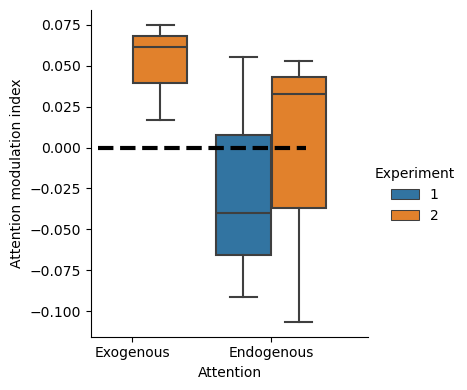

In [3]:
sns.catplot(y='value', x='Attention',  hue='Experiment',
            data=combined, kind='box',  height=4)
plt.hlines(0, -.25, 1.25, color='black', ls='--', lw=3)
plt.ylabel('Attention modulation index')

Text(49.828341049382715, 0.5, 'Attention modulation index')

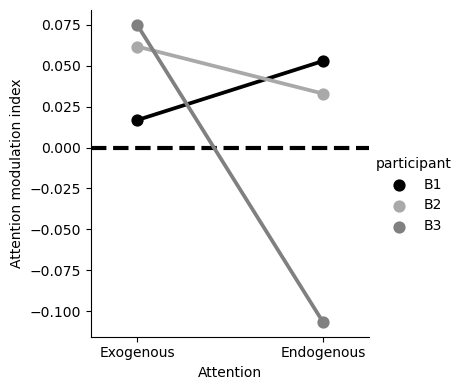

In [4]:
sns.catplot(y='value', x='Attention', hue='participant',
            data=ami, kind='point', palette=['black','darkgrey','grey'], height=4,)
plt.hlines(0, -.25, 1.25, color='black', ls='--', lw=3)
plt.xlim(-.25, 1.25)
plt.ylabel('Attention modulation index')

In [5]:
combined.loc[combined['Attention'] == 'Exogenous', 'Attention'] = 0
combined.loc[combined['Attention'] == 'Endogenous', 'Attention'] = 1
print(combined)

  participant     value Attention  Experiment
0          B1  0.016760         0           2
1          B1  0.052828         1           2
2          B2  0.061703         0           2
3          B2  0.032953         1           2
4          B3  0.074932         0           2
5          B3 -0.106473         1           2
0          A0  0.055267         1           1
1          A1 -0.091394         1           1
2          A2 -0.039701         1           1


In [6]:
md = smf.mixedlm("value ~ Attention", combined[combined.Experiment==2], groups=combined[combined.Experiment==2]["participant"])
mdf = md.fit()
print(mdf.summary())

          Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  value 
No. Observations:    6        Method:              REML  
No. Groups:          3        Scale:               0.0042
Min. group size:     2        Log-Likelihood:      4.1555
Max. group size:     2        Converged:           Yes   
Mean group size:     2.0                                 
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept       0.051    0.038  1.361 0.173 -0.022  0.125
Attention[T.1] -0.058    0.053 -1.092 0.275 -0.162  0.046
Group Var       0.000                                    



/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [7]:
md = smf.ols("value ~ Experiment", data=combined[combined.Attention==1])
mdf = md.fit()
print(mdf.summary())

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                 -0.226
Method:                 Least Squares   F-statistic:                   0.07754
Date:                Thu, 11 Jul 2024   Prob (F-statistic):              0.794
Time:                        11:00:05   Log-Likelihood:                 7.7948
No. Observations:                   6   AIC:                            -11.59
Df Residuals:                       4   BIC:                            -12.01
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0437      0.104     -0.418      0.6

/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


## 1.2 Coherence analysis

In [8]:
participants = ['B1', 'B2', 'B3'] 

ms_coh = []
for participant in participants:
    df_participant = pd.read_csv(f'files/ITcoh_{participant}.csv', index_col=False)
    df_participant['participant'] = participant
    ms_coh.append(df_participant)
ms_coh = pd.concat(ms_coh)
ms_coh['cued_group'] = (ms_coh['coh_with'] == ms_coh['cued'])
#Average over electrodes
ms_coh = ms_coh.groupby(['participant','condition','time','cued_group']).ITcoherence.mean().reset_index()


In [9]:
diff_coh = pd.merge(ms_coh[ms_coh.cued_group == True],
                    ms_coh[ms_coh.cued_group == False], 
                    on=['condition', 'time', 'participant'], suffixes=('_1', '_2'))

# Calculate the difference in ITcoherence
diff_coh['ms_coherence_diff'] = diff_coh['ITcoherence_2'] - diff_coh['ITcoherence_1']
diff_coh

,participant,condition,time,cued_group_1,ITcoherence_1,cued_group_2,ITcoherence_2,ms_coherence_diff
0,B1,endo,-0.500000,True,-0.890391,False,-1.211714,-0.321323
1,B1,endo,-0.499512,True,-0.988573,False,-1.198013,-0.209440
2,B1,endo,-0.499023,True,-1.053093,False,-1.189845,-0.136753
3,B1,endo,-0.498535,True,-1.093401,False,-1.185382,-0.091981
4,B1,endo,-0.498047,True,-1.129443,False,-1.181228,-0.051786
...,...,...,...,...,...,...,...,...
21505,B3,exo,1.248047,True,0.114805,False,-1.230987,-1.345793
21506,B3,exo,1.248535,True,0.076825,False,-1.238499,-1.315324
21507,B3,exo,1.249023,True,0.028714,False,-1.246991,-1.275706
21508,B3,exo,1.249512,True,-0.071132,False,-1.259879,-1.188747


/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1075

Text(0.5, 0, 'Time')

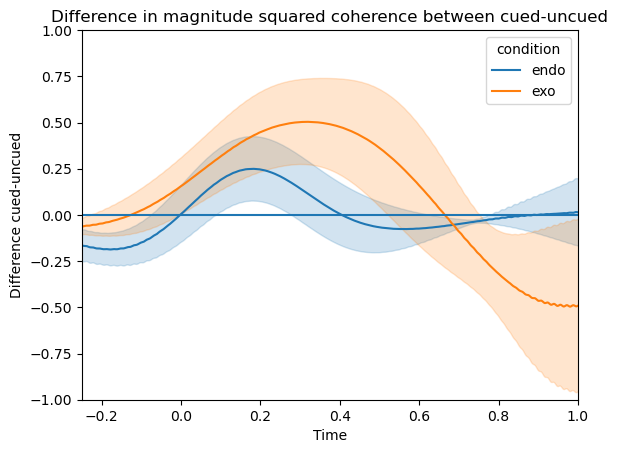

In [10]:
sns.lineplot(y='ms_coherence_diff', hue='condition', x='time', data=diff_coh, errorbar='se')
plt.hlines(0, -.25, 1)
plt.xlim(-.25, 1)
plt.ylim(-1, 1)
plt.title('Difference in magnitude squared coherence between cued-uncued')
plt.ylabel('Difference cued-uncued')
plt.xlabel('Time')

# 2. Decoding

In [11]:
participants = ['B1', 'B2', 'B3'] 
target_period = []
for participant in participants:
    df_participant = pd.read_csv(f'files/{participant}_target_period_pow.csv', index_col=False)
    df_participant['participant'] = participant
    target_period.append(df_participant)
target_period = pd.concat(target_period)

baseline_period = []
for participant in participants:
    df_participant = pd.read_csv(f'files/{participant}_baseline_pow.csv', index_col=False)
    df_participant['participant'] = participant
    baseline_period.append(df_participant)
baseline_period = pd.concat(baseline_period)

p_value = 1-0.05/len(target_period.time.unique())

# Determine chance level based on best predictor during baseline
chance1, chance99 = np.percentile(baseline_period.groupby(['time']).score.mean(), q=[.1, 99.9])

/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1075

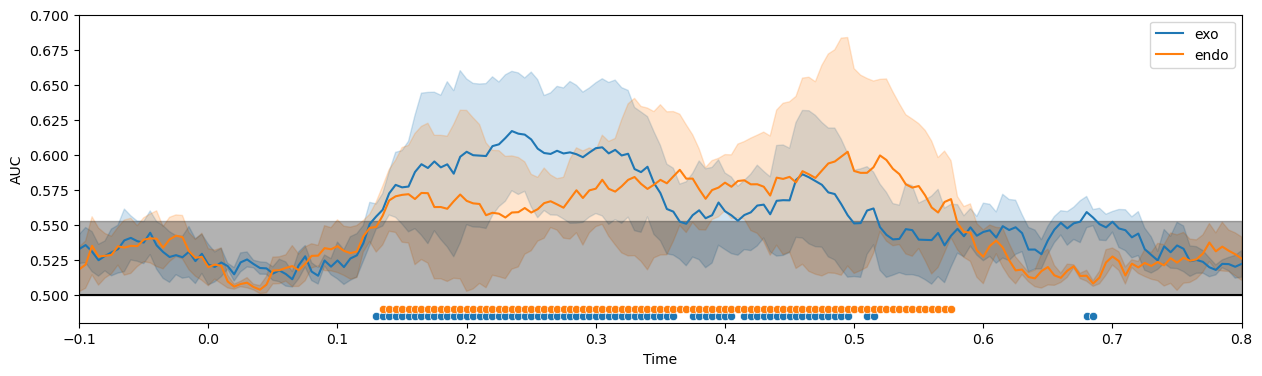

In [12]:
plt.subplots(figsize=(15,4))
sns.lineplot(y='score', hue='attention', x='time', data=target_period, errorbar='se')
plt.hlines(.5, -1, 2.3, 'k')
plt.ylabel('AUC')
plt.xlabel('Time')
plt.xlim(-.1,.8)
plt.fill_betweenx([.5, chance99], -.1, 0.8, color='black', alpha=0.3)
plt.ylim(.48, .7)

target_period_mean = target_period.groupby(['attention', 'time']).mean('score').reset_index()
higher_than_chance = target_period_mean[target_period_mean['score'] > chance99]
for attention, y_val in [('exo', 0.485),('endo', 0.49)]:
    filtered_data = higher_than_chance[higher_than_chance['attention'] == attention]
    sns.scatterplot(x=filtered_data['time'], y=[y_val]*len(filtered_data))
